In [117]:
# 텐서플로우 일일 빌드버전

!pip install -q tf-nightly

In [118]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from glob import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tqdm import tqdm

import pandas as pd
import matplotlib.patches as patches
import cv2
import warnings
import torch
import json

In [119]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [120]:
# pathlib를 통해 경로관리 편하게

import pathlib

path = pathlib.Path('/content/drive/MyDrive/T1_PJ/DATA/이미지 폴더/테스트용')
path1 = '/content/drive/MyDrive/T1_PJ/DATA/이미지 폴더'
path2 = '/content/drive/MyDrive/T1_PJ/DATA/이미지 폴더/테스트용/'

In [121]:
# 해당경로 하위에 있는 jpg 파일 개수 알아보기

image_count = len(list(path.glob('*/*.jpg')))
print(image_count)

2195


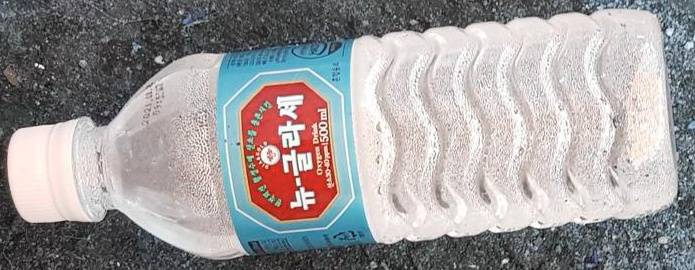

In [122]:
# 해당위치의 첫번째 데이터

PET = list(path.glob('fill/*'))
PIL.Image.open(str(PET[0]))

In [123]:
# 배치사이즈, 이미지 사이즈 설정

batch_size = 8
img_height = 256
img_width = 256

In [124]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2195 files belonging to 5 classes.
Using 1756 files for training.


In [125]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2195 files belonging to 5 classes.
Using 439 files for validation.


In [126]:
class_names = train_ds.class_names
print(class_names)

['color', 'dirty', 'fill', 'tag', '라벨 잔존']


In [127]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(8, 256, 256, 3)
(8,)


In [128]:
# 정규화 작업

normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [129]:
# 정규화 작업

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image)) 

0.0 1.0


In [130]:
# 어그멘테이션

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width,3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

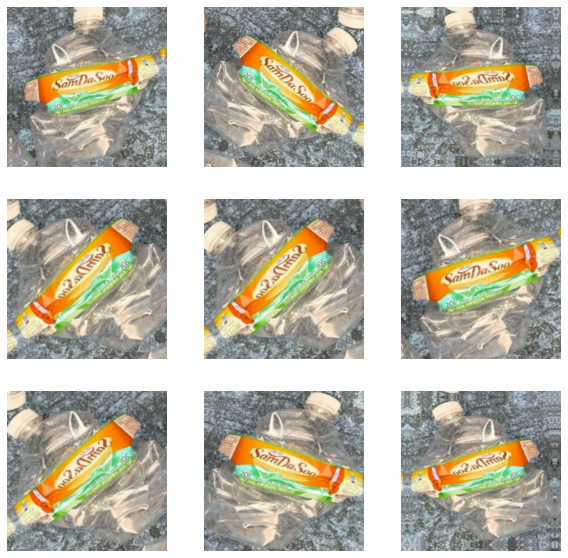

In [131]:
# 어그멘테이션

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [132]:
# 모델 작성
# Dropout 사용

num_classes = 5

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(256, 256, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [133]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [134]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_14 (Sequential)  (None, 256, 256, 3)       0         
                                                                 
 rescaling_16 (Rescaling)    (None, 256, 256, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 128, 128, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                

In [135]:
# 훈련

epochs=50

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
220/220 [==============================] - 537s 2s/step - loss: 0.3852 - accuracy: 0.8964 - val_loss: 0.2791 - val_accuracy: 0.9180
Epoch 2/50
220/220 [==============================] - 131s 593ms/step - loss: 0.3227 - accuracy: 0.9026 - val_loss: 0.2656 - val_accuracy: 0.9248
Epoch 3/50
220/220 [==============================] - 130s 588ms/step - loss: 0.3199 - accuracy: 0.8992 - val_loss: 0.2579 - val_accuracy: 0.9203
Epoch 4/50
220/220 [==============================] - 131s 593ms/step - loss: 0.3060 - accuracy: 0.8992 - val_loss: 0.2689 - val_accuracy: 0.9203
Epoch 5/50
220/220 [==============================] - 131s 594ms/step - loss: 0.3016 - accuracy: 0.9026 - val_loss: 0.2457 - val_accuracy: 0.9226
Epoch 6/50
220/220 [==============================] - 133s 605ms/step - loss: 0.2951 - accuracy: 0.9003 - val_loss: 0.2472 - val_accuracy: 0.9226
Epoch 7/50
220/220 [==============================] - 132s 600ms/step - loss: 0.2865 - accuracy: 0.8998 - val_loss: 0.2246 - va

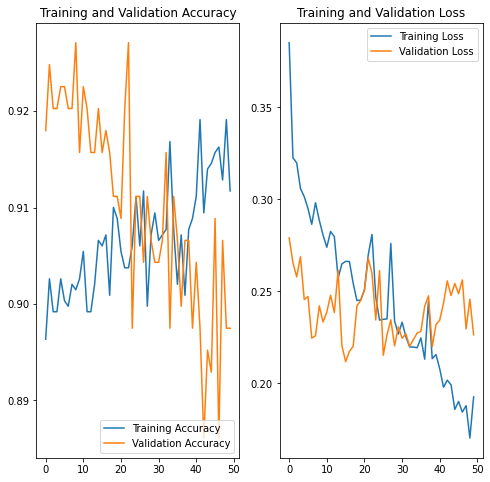

In [136]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

이 사진은 99.70070719718933% 확률로 tag 입니다


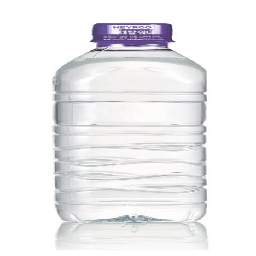

In [137]:
# 예측1


PET_path = '/content/drive/MyDrive/T1_PJ/DATA/test/pet8.jpg'

img = keras.preprocessing.image.load_img(
    PET_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "이 사진은 " + str(100 * np.max(score)) + "% 확률로 " +  class_names[np.argmax(score)] + ' 입니다')
img

이 사진은 53.112322092056274% 확률로 tag 입니다


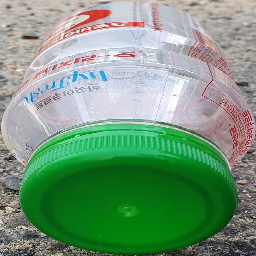

In [138]:
# 예측2


PET_path = '/content/drive/MyDrive/T1_PJ/DATA/test/pet2.jpg'

img = keras.preprocessing.image.load_img(
    PET_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "이 사진은 " + str(100 * np.max(score)) + "% 확률로 " +  class_names[np.argmax(score)] + ' 입니다')
img

이 사진은 62.74425387382507% 확률로 tag 입니다


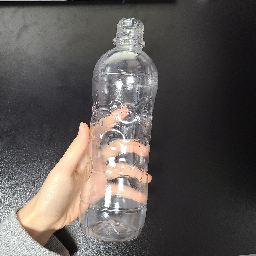

In [139]:
# 예측


PET_path = '/content/drive/MyDrive/T1_PJ/DATA/test/pet9.jpeg'

img = keras.preprocessing.image.load_img(
    PET_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "이 사진은 " + str(100 * np.max(score)) + "% 확률로 " +  class_names[np.argmax(score)] + ' 입니다')
img

In [140]:
# 모델 저장
#!pip install pyyaml h5py

In [141]:
#model.save('/content/drive/MyDrive/T1_PJ/CODE/PET_model.h5') 